In [1]:
# import the required packages
import numpy as np
import pandas as pd
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.preprocessing import LabelEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.feature_selection import chi2
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn. ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


## 1. Text Data Preprocessing

### 1.1 Load the Text Data

In [2]:
data = pd.read_csv('bbc-text.csv')

In [3]:
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

### 1.2 Cleanse the Text Data

In [6]:
data['text'][1]

'worldcom boss  left books alone  former worldcom boss bernie ebbers  who is accused of overseeing an $11bn (£5.8bn) fraud  never made accounting decisions  a witness has told jurors.  david myers made the comments under questioning by defence lawyers who have been arguing that mr ebbers was not responsible for worldcom s problems. the phone company collapsed in 2002 and prosecutors claim that losses were hidden to protect the firm s shares. mr myers has already pleaded guilty to fraud and is assisting prosecutors.  on monday  defence lawyer reid weingarten tried to distance his client from the allegations. during cross examination  he asked mr myers if he ever knew mr ebbers  make an accounting decision  .  not that i am aware of   mr myers replied.  did you ever know mr ebbers to make an accounting entry into worldcom books   mr weingarten pressed.  no   replied the witness. mr myers has admitted that he ordered false accounting entries at the request of former worldcom chief financi

In [7]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W|_)+"," ",text)
    
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)

#load a set of stop words
stopwords=get_stop_words("stopwords.txt")

processed_text = data['text'].apply(lambda x:pre_process(x))

In [8]:
processed_text[3]

'yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round the game arguably the highlight of the draw is a potential money spinner for non league yeading who beat slough in the second round conference side exeter city who knocked out doncaster on saturday will travel to old trafford to meet holders manchester united in january arsenal were drawn at home to stoke and chelsea will play host to scunthorpe the only other non league side in the draw are hinckley united who held brentford to a goalless draw on sunday they will meet league one leaders luton if they win their replay against martin allen s team at griffin park a number of premiership teams face difficult away games against championship sides on the weekend of january third placed everton visit plymouth liverpool travel to burnley crystal palace go to sunderland fulham face carling cup semi finalists watford bolton meet ipswich while aston vi

### 1.3 Bag-of-Word

In [9]:
count_vect = CountVectorizer(max_df=0.5, stop_words=stopwords, max_features=5000)
text_counts = count_vect.fit_transform(processed_text.tolist())

In [12]:
count_vect.stop_words_

{'calculator',
 'parallels',
 'shout',
 'diplomatic',
 'undervaluing',
 'revoke',
 'noises',
 'romancing',
 'schuettler',
 'threatend',
 'permissive',
 'erase',
 'forgiving',
 'schleswig',
 'symbols',
 'regulating',
 'manually',
 'warrington',
 'blairite',
 'hanningfield',
 'templeton',
 'ridicule',
 'desailly',
 'yili',
 'stamps',
 'softer',
 'harbours',
 'wearable',
 'disengage',
 'appointees',
 'desai',
 'szilard',
 'confessions',
 'lieberman',
 'nationality',
 'essence',
 'brunswick',
 'occupies',
 'stoppage',
 'inaugural',
 'lizard',
 'roughly',
 'marker',
 'mafeca',
 'melua',
 'inventors',
 'socially',
 'crammed',
 'inspiration',
 'khomeini',
 'thirties',
 'debuted',
 'racked',
 'finsbury',
 'epicentre',
 'neulling',
 'convergence',
 'brandy',
 'controversially',
 'rockscape',
 'civilised',
 'comair',
 'odeon',
 'reintroducing',
 'clinching',
 'horsepower',
 'annie',
 'outsourcing',
 'cauldron',
 'bonar',
 'olivia',
 'ltd',
 'blanchard',
 'exploring',
 'striving',
 'col',
 'armed

In [11]:
sum_words = text_counts.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [12]:
print('The highest frequency words:')
words_freq[0:20] 

The highest frequency words:


[('people', 2045),
 ('time', 1322),
 ('world', 1201),
 ('government', 1160),
 ('uk', 1115),
 ('bn', 958),
 ('told', 911),
 ('film', 890),
 ('game', 871),
 ('music', 839),
 ('labour', 804),
 ('bbc', 778),
 ('set', 762),
 ('added', 733),
 ('market', 702),
 ('company', 686),
 ('home', 663),
 ('election', 662),
 ('party', 630),
 ('games', 622)]

### 1.4 TF-IDF

In [13]:
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
text_tfidf = tfidf_transformer.fit_transform(text_counts)

In [14]:
feature_names=np.array(count_vect.get_feature_names())

# find maximum value for each of the features over dataset:
max_value = text_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['savvy' 'specifications' 'sadly' 'types' 'constantly' 'status' 'etc'
 'crimes' 'amongst' 'kinds' 'instant' 'purpose' 'changing' 'credibility'
 'finnish' 'maintaining' 'enforce' 'reaching' 'informed' 'globally']
Features with highest tfidf: 
['brando' 'stern' 'wmc' 'mirza' 'mitsubishi' 'copper' 'viacom' 'beer'
 'edwards' 'boeing' 'qantas' 'fiat' 'mtv' 'mutu' 'dallaglio' 'uwb' 'ink'
 'nissan' 'commodore' 'ballet']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [15]:
topn = 5 #top 5 keywords from each document
keywords = []


In [16]:
for idx, doc in processed_text.items():
    #generate tf-idf for the given document
    tf_idf_vector=text_tfidf[idx]
    
    temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
    temp.sort_values('tf_idf', ascending = False, inplace = True)

    #use only topn items from vector
    
    topn_items = temp[:topn]
    word = []
    
    for index, row in topn_items.iterrows():
        fname = feature_names[int(row['feature_number'])]
        word.append(fname)

    result = word
    keywords.append(result)


In [17]:
keywords

[['tv', 'definition', 'watch', 'satellite', 'content'],
 ['worldcom', 'ebbers', 'accounting', 'fraud', 'defence'],
 ['farrell', 'leicester', 'tigers', 'rugby', 'league'],
 ['league', 'west', 'cup', 'united', 'drawn'],
 ['ocean', 'sequel', 'twelve', 'starring', 'box'],
 ['howard', 'party', 'labour', 'election', 'michael'],
 ['parliament', 'election', 'blair', 'april', 'name'],
 ['henman', 'rain', 'seed', 'ljubicic', 'frustrating'],
 ['wilkinson', 'injury', 'edinburgh', 'england', 'newcastle'],
 ['wars', 'lucas', 'rating', 'film', 'star'],
 ['film', 'nazi', 'berlin', 'festival', 'distributing'],
 ['virgin', 'blue', 'profits', 'airline', 'shares'],
 ['prices', 'crude', 'oil', 'barrel', 'opec'],
 ['hague', 'ambition', 'party', 'front', 'bench'],
 ['roddick', 'moya', 'clay', 'davis', 'spain'],
 ['lg', 'card', 'creditors', 'korea', 'firm'],
 ['stem', 'cells', 'cell', 'research', 'howard'],
 ['connors', 'coaches', 'jimmy', 'kids', 'relationship'],
 ['mitsubishi', 'bank', 'japan', 'japanese', 

In [18]:
data['cleansed_text'] = processed_text
data['keywords'] = keywords
data.head()

,category,text,cleansed_text,keywords
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, definition, watch, satellite, content]"
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,"[worldcom, ebbers, accounting, fraud, defence]"
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,"[farrell, leicester, tigers, rugby, league]"
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[league, west, cup, united, drawn]"
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, sequel, twelve, starring, box]"


### 2.2 Association Rules Mining on keywords

In [19]:
keywordsCombined = []
for lists in keywords:
    for keyword in lists:  
        keywordsCombined.append(keyword)
keywordsSeries = pd.Series(keywordsCombined)

keywordsSeries.value_counts()

film          86
labour        59
bn            58
blair         57
election      51
              ..
listen         1
enterprise     1
agreements     1
earn           1
impact         1
Length: 3049, dtype: int64

In [20]:
keywordsSeries

0                tv
1        definition
2             watch
3         satellite
4           content
            ...    
11120       souness
11121          goal
11122          uefa
11123           cup
11124        graeme
Length: 11125, dtype: object

In [21]:
#filter and retrieve only the top 1000 keywords
filteredKeywords = keywordsSeries.value_counts().head(1000)
filteredKeywords

film        86
labour      59
bn          58
blair       57
election    51
            ..
ian          3
score        3
janet        3
chicago      3
try          3
Length: 1000, dtype: int64

In [22]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
data_encoded = te.fit_transform(keywords)
data_encoded = pd.DataFrame(data_encoded, columns = te.columns_)

# getting the shape of the data
data_encoded.shape

(2225, 3049)

In [23]:
# getting correlations for 3049 items would be messy 
# so let's reduce the items from 3049 to 1000

data_encoded = data_encoded.loc[:, filteredKeywords.index]

# checking the shape
data_encoded.shape

(2225, 1000)

In [24]:
data_encoded

,film,labour,bn,blair,election,brown,mobile,england,game,sales,...,compete,athletes,left,bus,drake,ian,score,janet,chicago,try
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2221,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2222,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2223,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
#minimum support must be lower because these words have a low frequency
frequent_itemsets=apriori(data_encoded, min_support = 0.001, use_colnames = True)
frequent_itemsets

,support,itemsets
0,0.038652,(film)
1,0.026517,(labour)
2,0.026067,(bn)
3,0.025618,(blair)
4,0.022921,(election)
...,...,...
1872,0.001348,"(prescott, choice, pension, workers)"
1873,0.001348,"(unions, prescott, choice, workers)"
1874,0.001348,"(unions, prescott, choice, pension)"
1875,0.001348,"(kilroy, silk, party, veritas, ukip)"


In [26]:
rules_c = association_rules(frequent_itemsets, metric="confidence")
rules_c.sort_values('confidence', ascending=False, inplace = True)
rules_c.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(poster),(labour),0.001798,0.026517,0.001798,1.0,37.711864,0.001750,inf
366,"(black, ethnic)",(minority),0.001348,0.001798,0.001348,1.0,556.250000,0.001346,inf
364,"(prescott, choice)",(unions),0.001348,0.003596,0.001348,1.0,278.125000,0.001343,inf
363,"(unions, prescott)",(choice),0.001348,0.002697,0.001348,1.0,370.833333,0.001345,inf
362,(hunts),"(hunting, hunt)",0.001798,0.002697,0.001798,1.0,370.833333,0.001793,inf


In [27]:
rules_l = association_rules(frequent_itemsets, metric="lift")
rules_l.sort_values('lift', ascending=False, inplace = True)
rules_l.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1745,(fightstar),"(simpson, band)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
2376,(ie),"(browser, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
2553,"(microsoft, browser, explorer)",(ie),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1825,(ie),"(microsoft, browser)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1820,"(microsoft, browser)",(ie),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf


In [28]:
rules_c[ (rules_c['lift'] >= 741) &
       (rules_c['confidence'] >= 1) ].head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
380,(ie),"(browser, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
378,"(browser, explorer)",(ie),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
430,(ie),"(microsoft, browser, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
429,"(ie, explorer)","(microsoft, browser)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
428,"(browser, explorer)","(microsoft, ie)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf


### 2.3 Chi-squared test

In [29]:
data['category_id'] = data['category'].factorize()[0]
labels = data.category_id
data['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [30]:
category_to_id = {'tech':0, 'business':1, 'sport':2, 'entertainment':3, 'politics':4}
id_to_category = {0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [33]:
N = 5  

for Category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(text_tfidf, labels == category_id)                 
    indices = np.argsort(features_chi2[0])                                 
    feature_names = np.array(count_vect.get_feature_names())[indices]            
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]        
    print("# '{}':".format(Category))
    print("  . Most correlated keywords:\n       . {}".format('\n       . '.join(unigrams[-N:])))

# 'business':
  . Most correlated keywords:
       . shares
       . oil
       . bank
       . growth
       . bn
# 'entertainment':
  . Most correlated keywords:
       . awards
       . album
       . festival
       . band
       . film
# 'politics':
  . Most correlated keywords:
       . brown
       . party
       . election
       . blair
       . labour
# 'sport':
  . Most correlated keywords:
       . coach
       . england
       . injury
       . match
       . cup
# 'tech':
  . Most correlated keywords:
       . computer
       . technology
       . software
       . users
       . mobile


### 2.4 WordCloud on keywords

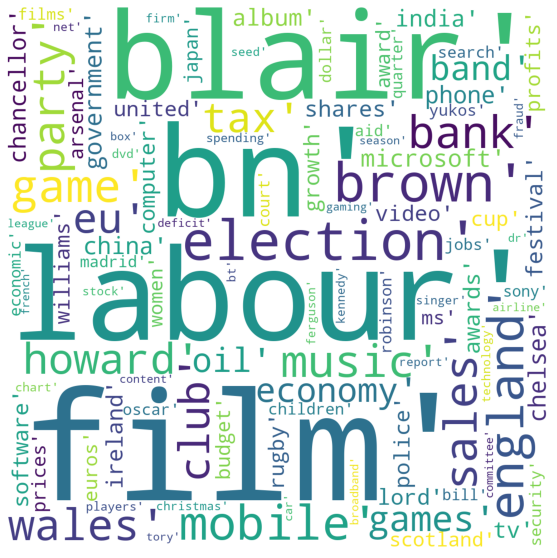

In [142]:
#IGNORE THIS. THIS IS CREATED TO SHOW WHAT HAPPENS IF I USED THE NESTED LIST TO GENERATE THE WORDCLOUD
plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 100).generate(str(keywords))
plt.imshow(wordcloud)
plt.axis('off')
#plt.title('Highest Frequency TF-IDF Keywords',fontsize = 20)
plt.show()

In [183]:
keywordsSplit = ''

for lists in keywords:
    for keyword in lists:
        keywordsSplit += keyword+" "
        
keywordsSplit

'tv definition watch satellite content worldcom ebbers accounting fraud defence farrell leicester tigers rugby league league west cup united drawn ocean sequel twelve starring box howard party labour election michael parliament election blair april name henman rain seed ljubicic frustrating wilkinson injury edinburgh england newcastle wars lucas rating film star film nazi berlin festival distributing virgin blue profits airline shares prices crude oil barrel opec hague ambition party front bench roddick moya clay davis spain lg card creditors korea firm stem cells cell research howard connors coaches jimmy kids relationship mitsubishi bank japan japanese trillion argonaut games cash london save fbi mails attachment virus computer bandwidth traffic halo gaming explosion bates leeds club takeover board villa cole leary ankle operation sound mobile audio technology handsets moya atp relief tournament prize dicaprio hughes aviator film actor gig phones mobile phone video clarke terror powe

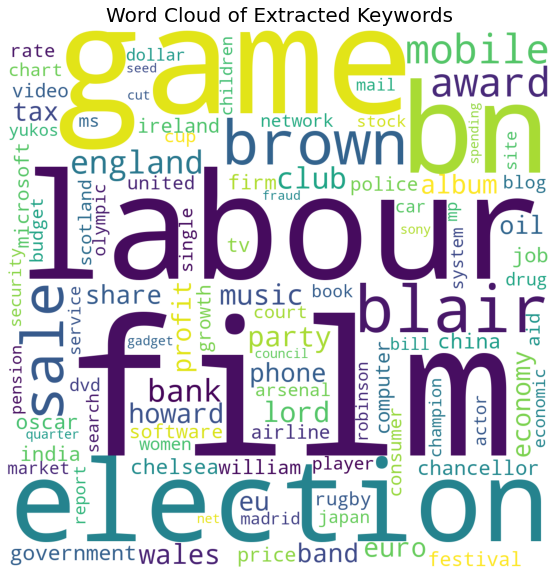

In [184]:
plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 100).generate(str(keywordsSplit))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Extracted Keywords',fontsize = 20)
plt.show()

## 3. Classification Modeling

### 3.1 Sample the data

In [16]:
X = text_tfidf.toarray()
encoder = LabelEncoder()
y = encoder.fit_transform(data['category'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

### 3.2 Build the Model(s)

Since there are so many types of machine learning models, from linear models to baysien models, I will be building one from each type.

Logistic Regression (Linear Model)

In [17]:
# Create the logistic regression
lg = LogisticRegression(multi_class='multinomial', random_state = 4)
# Fit the model to the training set
lg.fit(X_train,y_train)

LogisticRegression(multi_class='multinomial', random_state=4)

Random Forest (Ensemble Model)

In [18]:
#create random forest
rf = RandomForestClassifier(random_state = 4) 
rf.fit(X_train,y_train) 

RandomForestClassifier(random_state=4)

Multinomial Naive Bayes (Baysian Model)

In [19]:
# Creating Multinomial Naive Bayes (Baysian Model)
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

### 3.3 Evaluate and Improve the Model(s)

In [140]:
lg_results  = cross_validate(lg, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', lg_results['train_score'])
print('test_score: ', lg_results['test_score'])

print('cross val training accuracy is:', sum(lg_results['train_score'])/len(lg_results['train_score']))
print('cross val testing accuracy is:', sum(lg_results['test_score'])/len(lg_results['test_score']))

train_score:  [0.99606742 0.99662921 0.99606742 0.99606742 0.99662921]
test_score:  [0.98202247 0.98202247 0.98426966 0.9752809  0.97752809]
cross val training accuracy is: 0.9962921348314607
cross val testing accuracy is: 0.9802247191011236


In [141]:
rf_results  = cross_validate(rf, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', rf_results['train_score'])
print('test_score: ', rf_results['test_score'])

print('cross val training accuracy is:', sum(rf_results['train_score'])/len(rf_results['train_score']))
print('cross val testing accuracy is:', sum(rf_results['test_score'])/len(rf_results['test_score']))

train_score:  [1. 1. 1. 1. 1.]
test_score:  [0.95955056 0.97303371 0.96404494 0.94157303 0.96853933]
cross val training accuracy is: 1.0
cross val testing accuracy is: 0.9613483146067414


In [142]:
nb_results  = cross_validate(nb, X, y, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', nb_results['train_score'])
print('test_score: ', nb_results['test_score'])

print('cross val training accuracy is:', sum(nb_results['train_score'])/len(nb_results['train_score']))
print('cross val testing accuracy is:', sum(nb_results['test_score'])/len(nb_results['test_score']))

train_score:  [0.98820225 0.98876404 0.98764045 0.98764045 0.98595506]
test_score:  [0.97977528 0.9752809  0.98202247 0.95955056 0.9752809 ]
cross val training accuracy is: 0.9876404494382023
cross val testing accuracy is: 0.9743820224719102


### Confusion Matrix: Evaluating whether a model's prediction is balanced

In [20]:
#obtain all the category
category = []
for x in data['category']:
    if x not in category:
        category.append(x)
        
category

['tech', 'business', 'sport', 'entertainment', 'politics']

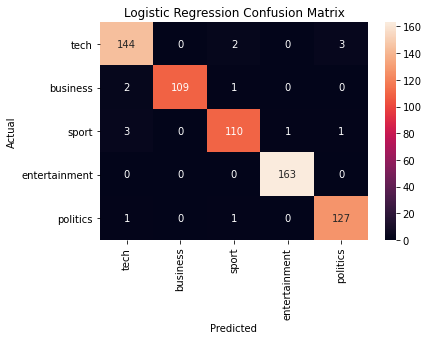

In [24]:
y_pred = lg.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category, yticklabels=category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

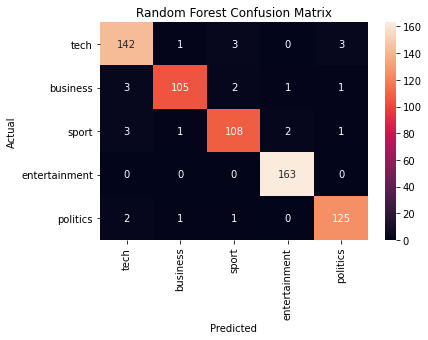

In [72]:
y_pred = rf.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category, yticklabels=category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix')
plt.show()

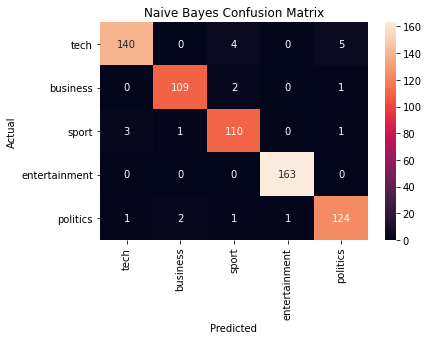

In [73]:
y_pred = nb.predict(X_test)

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category, yticklabels=category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [149]:
data['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

### Stratified Sampling

In [21]:
minimumDoc = min(data.category.value_counts()) #minimum amount of documents
tempList = [] #temporary list to store the stratified lists of each category (those that are > minimum doc)

#a loop to go through all the categories and perform stratified sampling.
for i in category:
    if (len(data[data['category']==i])) > minimumDoc:
        temp = data[data['category']==i]
        temp_sampled = temp.sample(n=minimumDoc, random_state=2).copy()
        tempList.append(temp_sampled)
    else: #if the number of documents in the specific category matches the minimum docs, stratified sampling is not used.
        temp = data[data['category']==i]
        tempList.append(temp)
        
stratifiedData=pd.concat(tempList,axis=0)
stratifiedData.reset_index(inplace=True)
stratifiedData.category.value_counts()

tech             386
sport            386
business         386
politics         386
entertainment    386
Name: category, dtype: int64

In [22]:
processed_text = stratifiedData['text'].apply(lambda x:pre_process(x))

In [23]:
count_vect = CountVectorizer(max_df=0.5, stop_words=stopwords, max_features=5000)
text_counts = count_vect.fit_transform(processed_text.tolist())
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
text_tfidf = tfidf_transformer.fit_transform(text_counts)

In [24]:
X2 = text_tfidf.toarray()
encoder = LabelEncoder()
y2 = encoder.fit_transform(stratifiedData['category'])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=2)

### Rebuild the models using the new stratified data

In [25]:
from sklearn.linear_model import LogisticRegression
# Create the logistic regression (Linear Model)
lg = LogisticRegression(multi_class='multinomial', random_state = 4)
# Fit the model to the training set
lg.fit(X2_train, y2_train)

LogisticRegression(multi_class='multinomial', random_state=4)

In [147]:
from sklearn. ensemble import RandomForestClassifier
#create random forest
rf = RandomForestClassifier(random_state = 4) 
rf.fit(X2_train, y2_train) 

RandomForestClassifier(random_state=4)

In [80]:
from sklearn.naive_bayes import MultinomialNB
# Creating Multinomial Naive Bayes (Baysien Model)
nb = MultinomialNB()
nb.fit(X2_train, y2_train)

MultinomialNB()

### Confusion Matrix: Evaluating whether a model's prediction is balanced

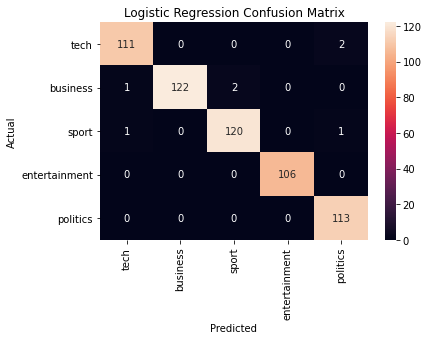

In [84]:
y_pred = lg.predict(X2_test)

conf_mat = confusion_matrix(y2_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category, yticklabels=category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

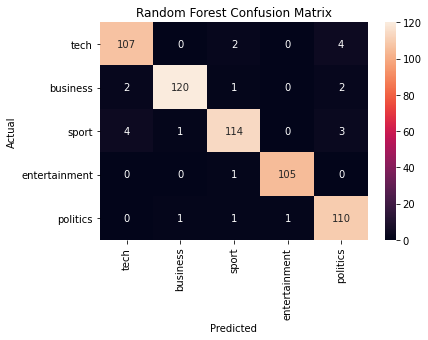

In [85]:
y_pred = rf.predict(X2_test)

conf_mat = confusion_matrix(y2_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category, yticklabels=category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Random Forest Confusion Matrix')
plt.show()

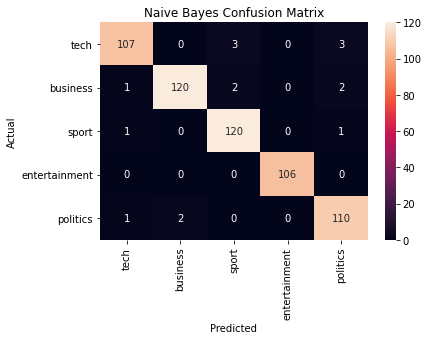

In [86]:
y_pred = nb.predict(X2_test)

conf_mat = confusion_matrix(y2_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category, yticklabels=category)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

### Re-evaluate the models using the new stratified data

In [159]:
lg_results  = cross_validate(lg, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', lg_results['train_score'])
print('test_score: ', lg_results['test_score'])

print('cross val training accuracy is:', sum(lg_results['train_score'])/len(lg_results['train_score']))
print('cross val testing accuracy is:', sum(lg_results['test_score'])/len(lg_results['test_score']))

train_score:  [0.99676166 0.99676166 0.99481865 0.99546632 0.99611399]
test_score:  [0.97927461 0.97150259 0.96891192 0.98963731 0.98186528]
cross val training accuracy is: 0.9959844559585491
cross val testing accuracy is: 0.978238341968912


In [160]:
rf_results  = cross_validate(rf, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', rf_results['train_score'])
print('test_score: ', rf_results['test_score'])

print('cross val training accuracy is:', sum(rf_results['train_score'])/len(rf_results['train_score']))
print('cross val testing accuracy is:', sum(rf_results['test_score'])/len(rf_results['test_score']))

train_score:  [1. 1. 1. 1. 1.]
test_score:  [0.95595855 0.95595855 0.96632124 0.9611399  0.96891192]
cross val training accuracy is: 1.0
cross val testing accuracy is: 0.9616580310880829


In [161]:
nb_results  = cross_validate(nb, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', nb_results['train_score'])
print('test_score: ', nb_results['test_score'])

print('cross val training accuracy is:', sum(nb_results['train_score'])/len(nb_results['train_score']))
print('cross val testing accuracy is:', sum(nb_results['test_score'])/len(nb_results['test_score']))

train_score:  [0.98834197 0.9876943  0.98704663 0.98510363 0.98704663]
test_score:  [0.96373057 0.96891192 0.96632124 0.97668394 0.98186528]
cross val training accuracy is: 0.9870466321243523
cross val testing accuracy is: 0.9715025906735753


### Model Hyperparameters Tuning

Logistic Regression: Model Tuning

In [87]:
lg_new = LogisticRegression(multi_class='multinomial', max_iter=1000, random_state=4)
param_grid = { 
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}

lg_gs = GridSearchCV(estimator=lg_new, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
lg_gs = lg_gs.fit(X2, y2)
print(lg_gs.best_score_)
print(lg_gs.best_params_)

0.978756476683938
{'C': 10, 'solver': 'newton-cg'}


In [88]:
lg_new = LogisticRegression(multi_class='multinomial', solver = 'newton-cg', max_iter=1000, random_state=4)
param_grid = { 
 'C': [5, 10, 30, 100]} 
lg_gs = GridSearchCV(estimator=lg_new, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
lg_gs = lg_gs.fit(X2, y2)
print(lg_gs.best_score_)
print(lg_gs.best_params_)

0.9813471502590675
{'C': 100}


In [162]:
lg_new = LogisticRegression(multi_class='multinomial', solver = 'newton-cg', max_iter=1000, random_state=4)
param_grid = { 
 'C': [70, 100, 200, 250]} 
lg_gs = GridSearchCV(estimator=lg_new, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
lg_gs = lg_gs.fit(X2, y2)
print(lg_gs.best_score_)
print(lg_gs.best_params_)

0.9818652849740934
{'C': 200}


In [29]:
C_range = range(100, 260, 20)
cross_val_train_acc =[]
cross_val_test_acc =[]

for d in C_range:

    lg_tune = LogisticRegression(multi_class='multinomial',
                                 C = d,
                                 solver = 'newton-cg',
                                 max_iter=1000,
                                 random_state=4)
    
    lg_tune.fit(X2_train, y2_train) 
    
    results  = cross_validate(lg_tune, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
    cross_val_train_acc.append(sum(results['train_score'])/len(results['train_score']))
    cross_val_test_acc.append(sum(results['test_score'])/len(results['test_score']))

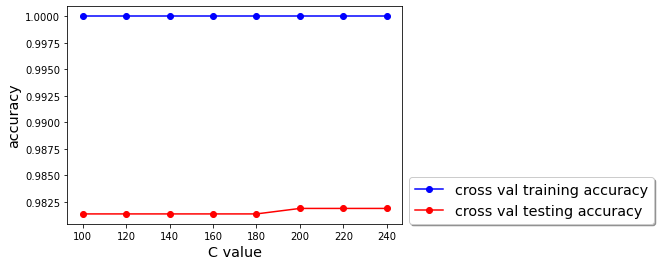

In [30]:
plt.plot(C_range, cross_val_train_acc, 'bo-', label ='cross val training accuracy')
plt.plot(C_range, cross_val_test_acc, 'ro-', label = 'cross val testing accuracy')

plt.xlabel('C value', fontsize='x-large')
plt.ylabel('accuracy', fontsize='x-large')

plt.legend(loc=(1.02,0), shadow=True, fontsize='x-large')
plt.show()

In [156]:
# Create the logistic regression (Linear Model)
lg_final = LogisticRegression(multi_class='multinomial', C=200, solver = 'newton-cg', max_iter=1000, random_state=4)
# Fit the model to the training set
lg_final.fit(X2_train, y2_train)

lg_results  = cross_validate(lg_final, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
print('train_score: ', lg_results['train_score'])
print('test_score: ', lg_results['test_score'])

print('cross val training accuracy is:', sum(lg_results['train_score'])/len(lg_results['train_score']))
print('cross val testing accuracy is:', sum(lg_results['test_score'])/len(lg_results['test_score']))

train_score:  [1. 1. 1. 1. 1.]
test_score:  [0.97927461 0.98186528 0.98186528 0.98445596 0.98186528]
cross val training accuracy is: 1.0
cross val testing accuracy is: 0.9818652849740934


Random Forest: Tuning

In [98]:
rf_new = RandomForestClassifier(random_state=4, n_jobs=-1)
param_grid = { 
 "criterion" : ['gini', 'entropy'],
 "max_features": ['auto', 'sqrt', 'log2'],
 "max_depth": [20, 40, 60],   #measures the depth of each tree, higher means more complex.
 "min_samples_leaf" : [2, 4, 7, 9],  #higher means less overfit, default is 2.
 "min_samples_split" : [1, 4, 6],  #default is 1
 "n_estimators": [70, 100, 130]}  #number of trees in the model.
rf_gs = GridSearchCV(estimator=rf_new, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
rf_gs = rf_gs.fit(X2, y2)
print(rf_gs.best_score_)
print(rf_gs.best_params_)

C:\Users\tyd\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.95336788 0.95906736 0.95854922
 0.95595855 0.95647668 0.95958549        nan        nan        nan
 0.95284974 0.95699482 0.95958549 0.95284974 0.95699482 0.95958549
        nan        nan        nan 0.94870466 0.95233161 0.95492228
 0.94870466 0.95233161 0.95492228        nan        nan        nan
 0.94870466 0.95440415 0.95492228 0.94870466 0.95440415 0.95492228
        nan        nan        nan 0.95803109 0.96217617 0.9642487
 0.95803109 0.96010363 0.9611399         nan        nan        nan
 0.95699482 0.95854922 0.96217617 0.95699482 0.95854922 0.96217617
        nan        nan        nan 0.95440415 0.95647668 0.9611399
 0.95440415 0.95647668 0.9611399         nan        nan        nan
 0.95025907 0.95440415 0.95906736 0.95025907 0.95440415 0.95906736
        nan        nan        nan 0.95958549 0.9611399  0

0.9694300518134715
{'criterion': 'gini', 'max_depth': 60, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 130}


In [99]:
rf_new = RandomForestClassifier(criterion = 'gini', max_features='log2', random_state=4, n_jobs=-1)
param_grid = { 
 "max_depth": [50, 60, 90],   #measures the depth of each tree, higher means more complex.
 "min_samples_leaf" : [1, 2, 3],  #higher means less overfit, default is 2.
 "min_samples_split" : [5, 6, 13],  #default is 1
 "n_estimators": [110, 130, 150]}  #number of trees in the model.
rf_gs = GridSearchCV(estimator=rf_new, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
rf_gs = rf_gs.fit(X2, y2)
print(rf_gs.best_score_)
print(rf_gs.best_params_)

0.9715025906735753
{'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 110}


In [102]:
#tune max_depth, min_samples_split and n_estimators individually

depth_range = range(40, 65, 5)
cross_val_train_acc =[]
cross_val_test_acc =[]

for d in depth_range:
    # Create Random Forest Model
    rf_tune = RandomForestClassifier(criterion='gini', n_estimators=110, random_state=4, min_samples_leaf = 1,
                             min_samples_split = 6,
                             max_features='log2',   
                                    max_depth=d)
    
    rf_tune.fit(X2_train, y2_train) 
    
    results  = cross_validate(rf_tune, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
    cross_val_train_acc.append(sum(results['train_score'])/len(results['train_score']))
    cross_val_test_acc.append(sum(results['test_score'])/len(results['test_score']))


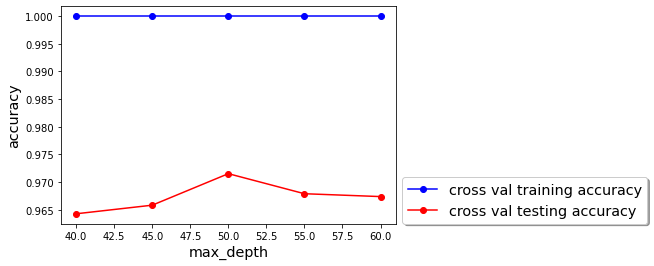

In [103]:
plt.plot(depth_range, cross_val_train_acc, 'bo-', label ='cross val training accuracy')
plt.plot(depth_range, cross_val_test_acc, 'ro-', label = 'cross val testing accuracy')

plt.xlabel('max_depth', fontsize='x-large')
plt.ylabel('accuracy', fontsize='x-large')

plt.legend(loc=(1.02,0), shadow=True, fontsize='x-large')
plt.show()

In [148]:
#tune max_depth, min_samples_split and n_estimators individually

split_range = range(6, 13)
cross_val_train_acc =[]
cross_val_test_acc =[]

for d in split_range:
    # Create Random Forest Model
    rf_tune = RandomForestClassifier(criterion='gini', n_estimators=110, random_state=4, min_samples_leaf = 1,
                             min_samples_split = d,
                             max_features='log2',   
                                    max_depth=50)
    rf_tune.fit(X2_train, y2_train) 
    
    results  = cross_validate(rf_tune, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
    cross_val_train_acc.append(sum(results['train_score'])/len(results['train_score']))
    cross_val_test_acc.append(sum(results['test_score'])/len(results['test_score']))


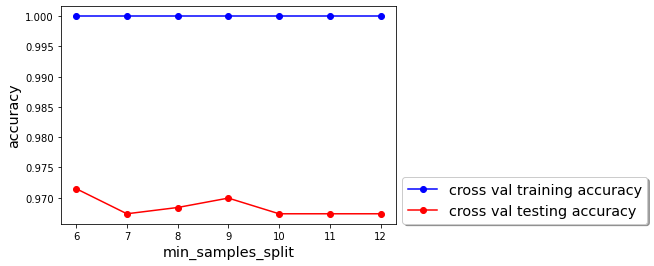

In [149]:
plt.plot(split_range, cross_val_train_acc, 'bo-', label ='cross val training accuracy')
plt.plot(split_range, cross_val_test_acc, 'ro-', label = 'cross val testing accuracy')

plt.xlabel('min_samples_split', fontsize='x-large')
plt.ylabel('accuracy', fontsize='x-large')

plt.legend(loc=(1.02,0), shadow=True, fontsize='x-large')
plt.show()

In [156]:
#tune max_depth, min_samples_split and n_estimators individually

estimators_range = range(100, 140, 10)
cross_val_train_acc =[]
cross_val_test_acc =[]

for d in estimators_range:
    # Create Random Forest Model
    rf_tune = RandomForestClassifier(criterion='gini', n_estimators=d, random_state=4, min_samples_leaf = 1,
                             min_samples_split = 6,
                             max_features='log2',   
                                    max_depth=50)
    rf_tune.fit(X2_train, y2_train) 
    
    results  = cross_validate(rf_tune, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
    cross_val_train_acc.append(sum(results['train_score'])/len(results['train_score']))
    cross_val_test_acc.append(sum(results['test_score'])/len(results['test_score']))


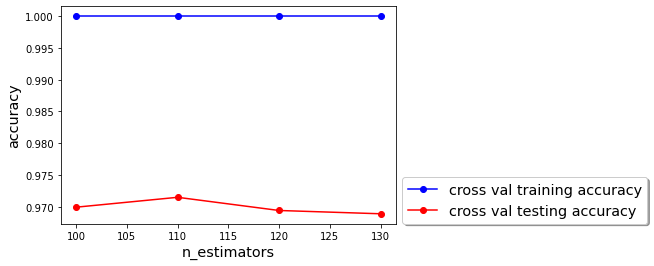

In [157]:
plt.plot(estimators_range, cross_val_train_acc, 'bo-', label ='cross val training accuracy')
plt.plot(estimators_range, cross_val_test_acc, 'ro-', label = 'cross val testing accuracy')

plt.xlabel('n_estimators', fontsize='x-large')
plt.ylabel('accuracy', fontsize='x-large')

plt.legend(loc=(1.02,0), shadow=True, fontsize='x-large')
plt.show()

In [155]:
rf_final = RandomForestClassifier(criterion='gini', 
                             n_estimators=110,
                             max_depth=50,
                             min_samples_leaf = 1,
                             min_samples_split = 6,
                             max_features='log2',                             
                             random_state=4,
                             n_jobs=-1)

rf_final.fit(X2_train,y2_train)

print('***Final Model***')
print('training acc: ', rf_final.score(X2_train,y2_train))
print('testing acc: ', rf_final.score(X2_test,y2_test))
results  = cross_validate(rf_final, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

***Final Model***
training acc:  1.0
testing acc:  0.9723661485319517
cross val training accuracy is: 1.0
cross val testing accuracy is: 0.9715025906735753


### Evaluation of tuned models

In [29]:
lg_final = LogisticRegression(multi_class='multinomial', C=200, solver = 'newton-cg', max_iter=1000, random_state=4)
lg_final.fit(X2_train, y2_train)

lg_results  = cross_validate(lg_final, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
print('***Final Model***')
print('train_score: ', lg_results['train_score'])
print('test_score: ', lg_results['test_score'])
print('cross val training accuracy is:', sum(lg_results['train_score'])/len(lg_results['train_score']))
print('cross val testing accuracy is:', sum(lg_results['test_score'])/len(lg_results['test_score']))

***Final Model***
train_score:  [1. 1. 1. 1. 1.]
test_score:  [0.97927461 0.98186528 0.98186528 0.98445596 0.98186528]
cross val training accuracy is: 1.0
cross val testing accuracy is: 0.9818652849740934


In [30]:
rf_final = RandomForestClassifier(criterion='gini', 
                             n_estimators=110,
                             max_depth=50,
                             min_samples_leaf = 1,
                             min_samples_split = 6,
                             max_features='log2',                             
                             random_state=4,
                             n_jobs=-1)

rf_final.fit(X2_train,y2_train)

print('***Final Model***')
print('training acc: ', rf_final.score(X2_train,y2_train))
print('testing acc: ', rf_final.score(X2_test,y2_test))
results  = cross_validate(rf_final, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
print('cross val training accuracy is:', sum(results['train_score'])/len(results['train_score']))
print('cross val testing accuracy is:', sum(results['test_score'])/len(results['test_score']))

***Final Model***
training acc:  1.0
testing acc:  0.9723661485319517
cross val training accuracy is: 1.0
cross val testing accuracy is: 0.9715025906735753


In [31]:
nb = MultinomialNB()
nb.fit(X2_train, y2_train)

nb_results  = cross_validate(nb, X2, y2, scoring='accuracy', cv=5, return_train_score = True)
print('***Final Model***')
print('train_score: ', nb_results['train_score'])
print('test_score: ', nb_results['test_score'])
print('cross val training accuracy is:', sum(nb_results['train_score'])/len(nb_results['train_score']))
print('cross val testing accuracy is:', sum(nb_results['test_score'])/len(nb_results['test_score']))

***Final Model***
train_score:  [0.98834197 0.9876943  0.98704663 0.98510363 0.98704663]
test_score:  [0.96373057 0.96891192 0.96632124 0.97668394 0.98186528]
cross val training accuracy is: 0.9870466321243523
cross val testing accuracy is: 0.9715025906735753
